In [2]:
###### algunas cosas cambian si pongo como comentarios en el import de geoviews y hvplot (liberias conflictivas?)

import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
#import geoviews as g

import numpy as np
import scipy as sp
import networkx as nx

# plotting stuff
import matplotlib.pyplot as plt

plt.style.use("bmh")
import seaborn as sns  ###
import cartopy.crs as ccrs

sns.set(style="darkgrid")

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

import sys

sys.path.append("../")  # to import helpers
from scripts._helpers import sets_path_to_root

sets_path_to_root("pypsa-earth")

max_node_size = 1.0  # maximum size of a node for plotting purposes [used in plots]

This is the repository path:  /Users/adelehannotte/Pypsa-earth/pypsa-earth
Had to go 1 folder(s) up.


# Profile hydro

In [2]:
import xarray as xr
import pandas as pd
fp= os.getcwd() +  "/resources/renewable_profiles/profile_hydro.nc"

datas= xr.open_dataset(fp)
datas

<xarray.Dataset>
Dimensions:  (plant: 112, time: 8760)
Coordinates:
  * plant    (plant) object '0' '1' '4' '6' '7' ... '127' '128' '129' '130'
  * time     (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
Data variables:
    inflow   (plant, time) float64 ...

data to dataframe

In [3]:
inflow=datas.data_vars['inflow']
df=inflow.to_dataframe()
df

inflow
plant time                          
0     2013-01-01 00:00:00  18.410095
      2013-01-01 01:00:00  18.612014
      2013-01-01 02:00:00  18.987843
      2013-01-01 03:00:00  19.160429
      2013-01-01 04:00:00  19.107834
...                              ...
130   2013-12-31 19:00:00  39.960286
      2013-12-31 20:00:00  33.733226
      2013-12-31 21:00:00  22.847525
      2013-12-31 22:00:00  14.481474
      2013-12-31 23:00:00  11.422301

[981120 rows x 1 columns]

In [5]:
df_country=df.groupby(df.index.get_level_values('time')).sum()
#Total production in one year
df_country.sum()/1e6 #[TWh/a]
# EIA datas 2018="2.586" 2019="3.22047" 2020="2.94" TWh/a

inflow    32.091485
dtype: float64

# Add electricity

### Generator_t.p_max_pu

In [73]:
elec_network= os.getcwd() +  "/networks/elec.nc"
n_elec= pypsa.Network(elec_network)

INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, loads, storage_units, transformers


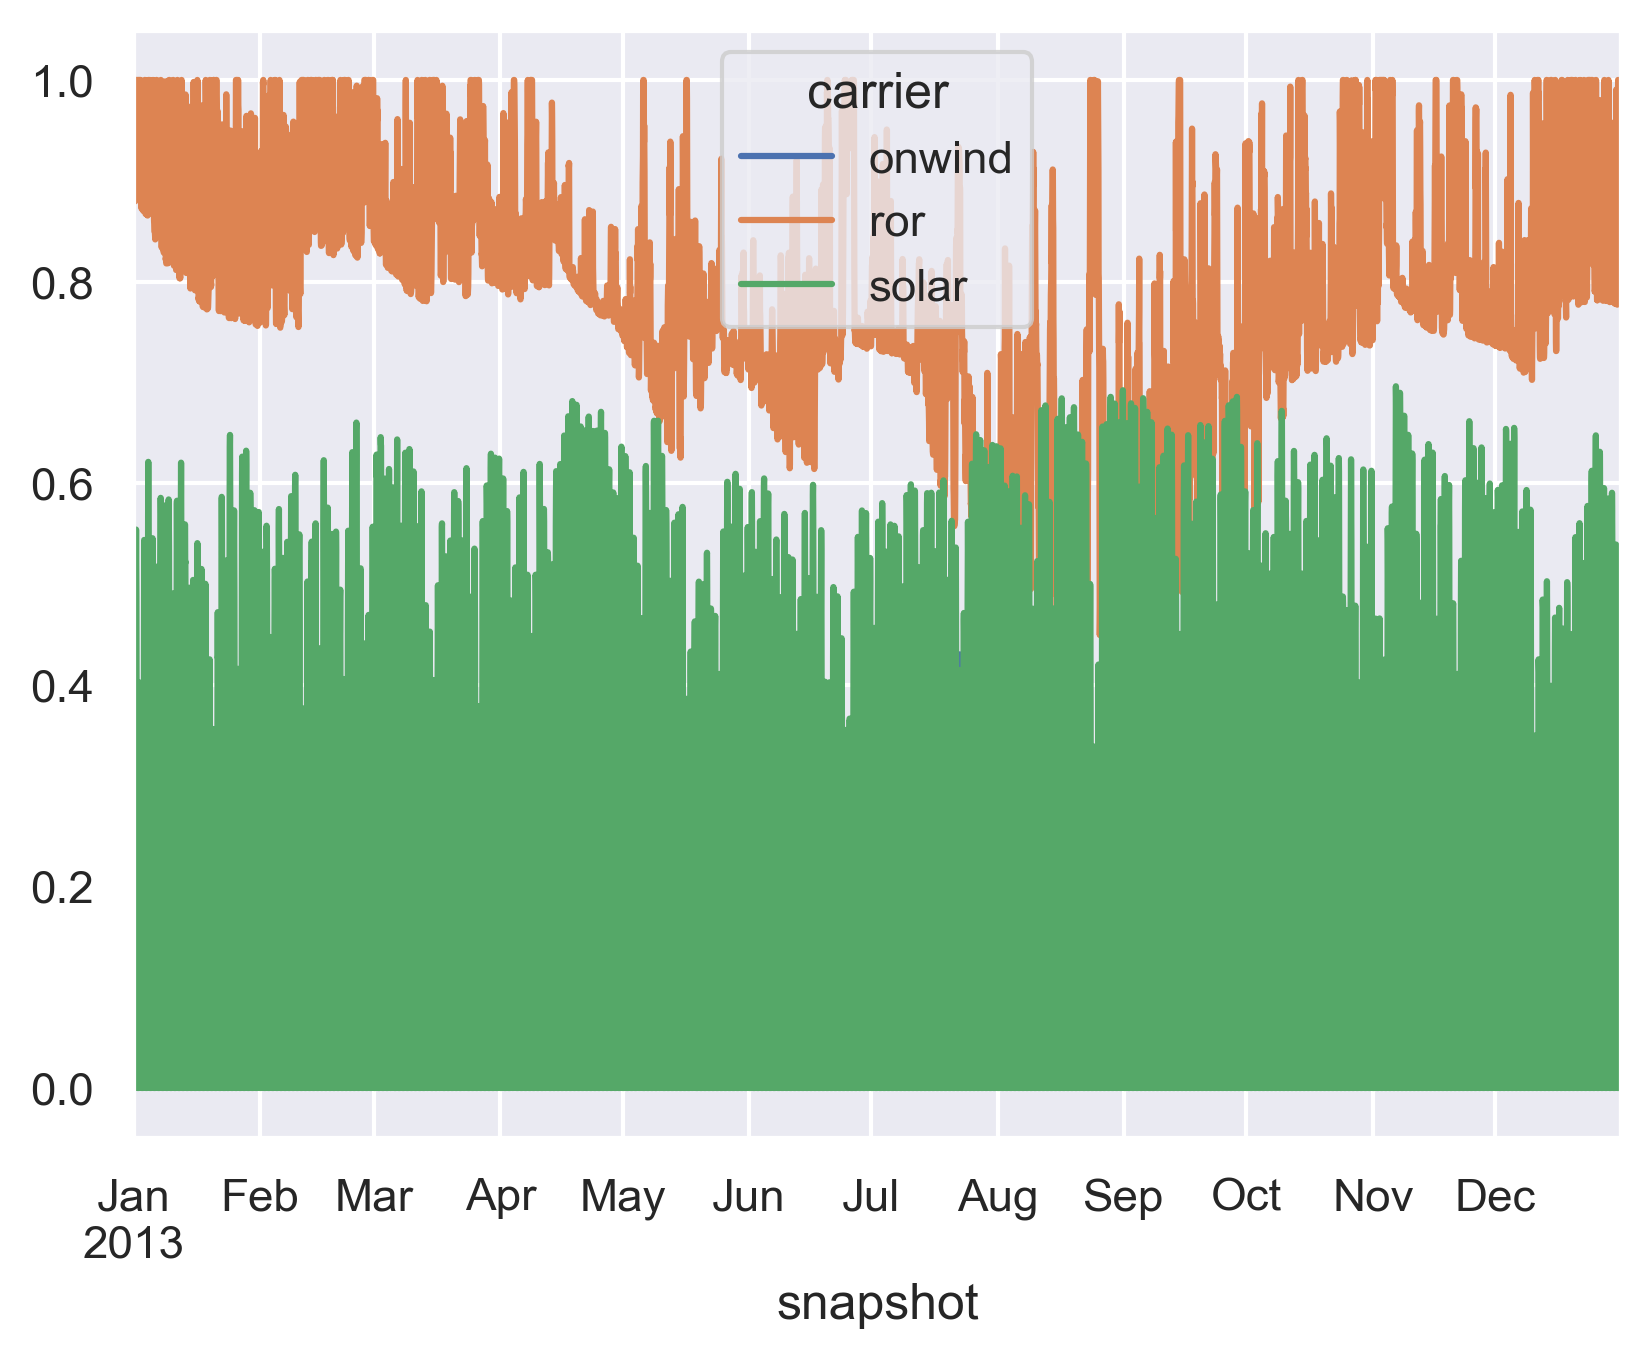

In [74]:
n_elec.generators_t.p_max_pu.groupby(n_elec.generators.carrier, axis=1).mean().plot()
plt.show()

<AxesSubplot:xlabel='snapshot'>

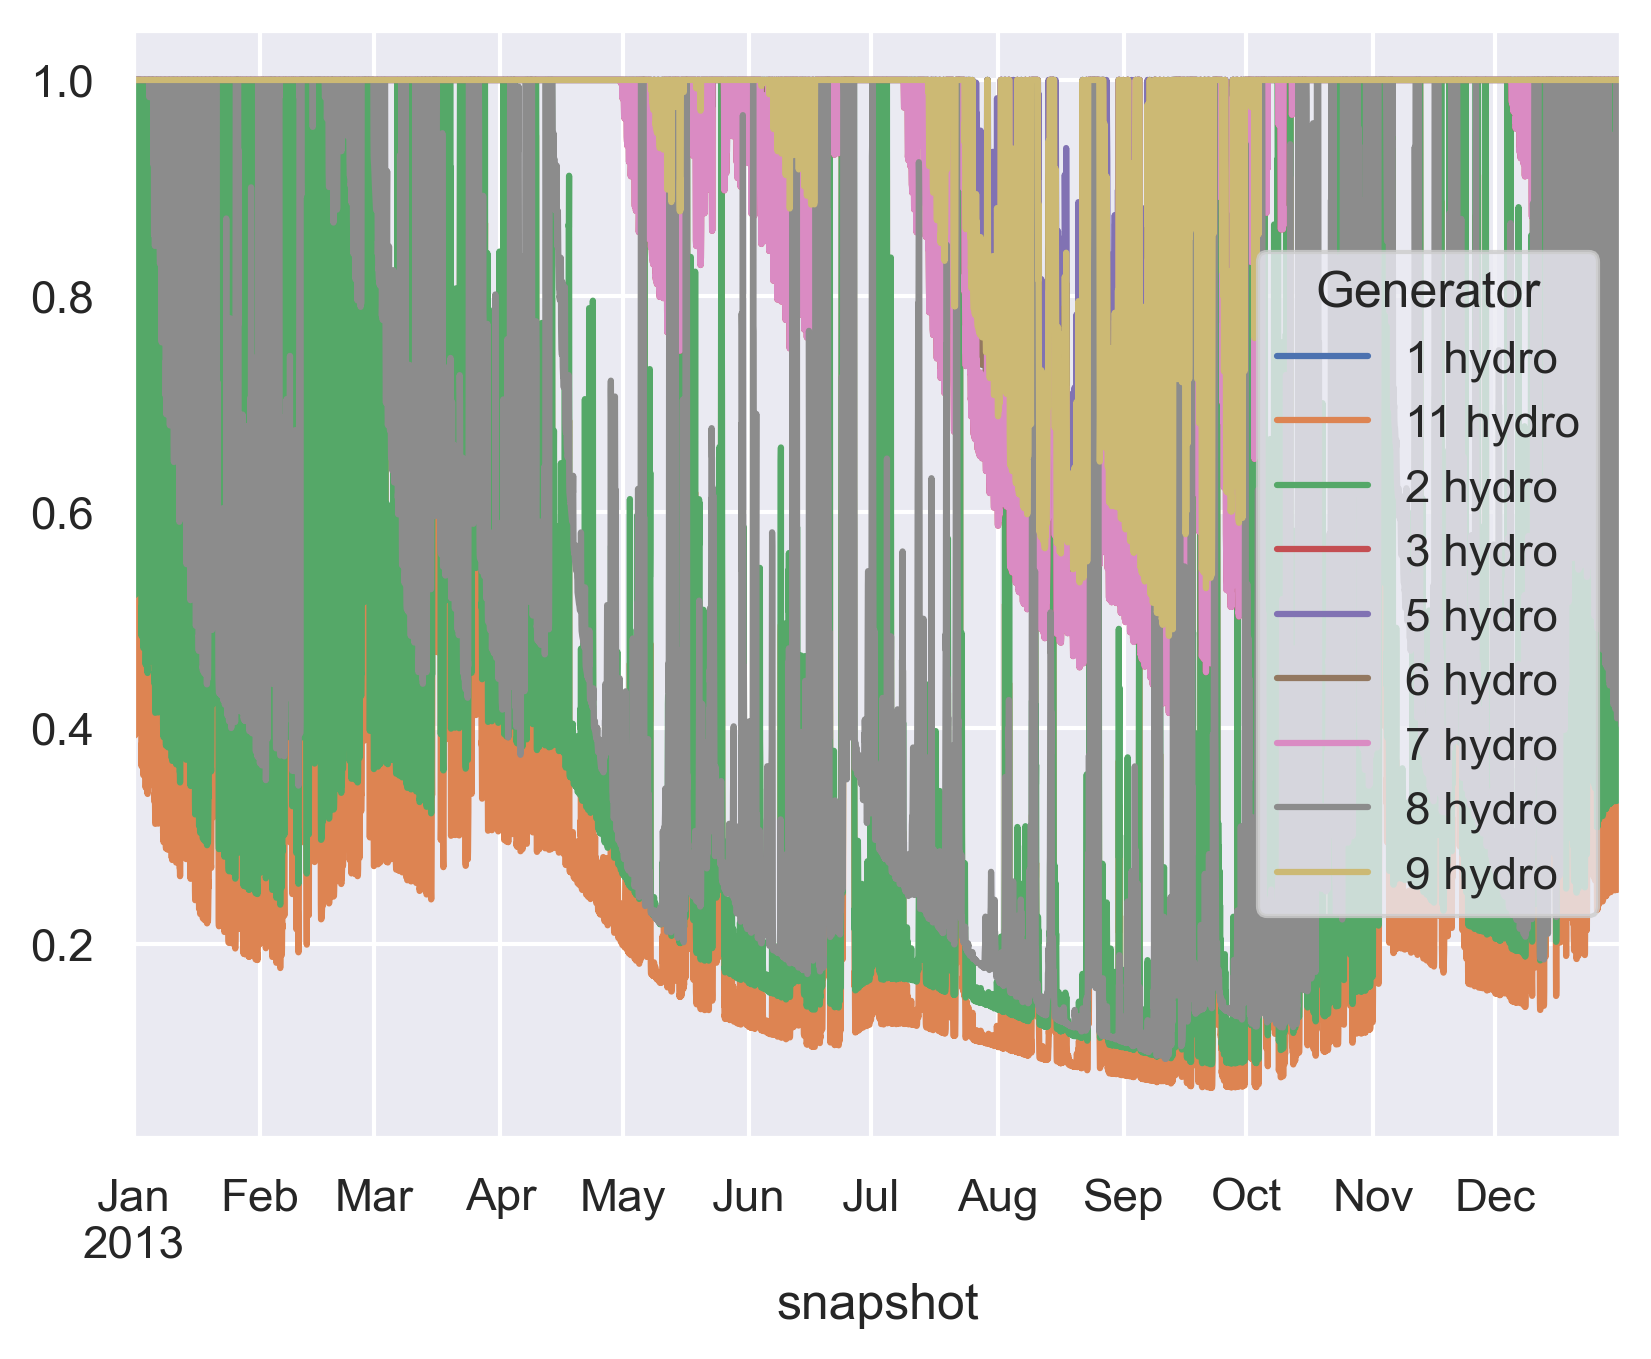

In [75]:
ror_generators = n_elec.generators[n_elec.generators.carrier == 'ror']
ror_columns = n_elec.generators_t.p_max_pu.columns[n_elec.generators_t.p_max_pu.columns.isin(ror_generators.index)]
ror_powerplants = n_elec.generators_t.p_max_pu[ror_columns]

ror_powerplants.plot()

In [76]:
ror_powerplants.mean().mean()

0.7702180668470883

In [77]:
n_elec.generators_t.p_max_pu.columns

Index(['0 onwind', '0 solar', '1 hydro', '1 onwind', '1 solar', '10 onwind',
       '10 solar', '100 onwind', '100 solar', '101 onwind',
       ...
       '95 onwind', '95 solar', '96 onwind', '96 solar', '97 onwind',
       '97 solar', '98 onwind', '98 solar', '99 onwind', '99 solar'],
      dtype='object', name='Generator', length=227)

Only 9 hydro power timeseries (in generators_t), but 11 hydro generator installed (in generator)
the more little one (0 hydro and 10 hydro) are not taken into account in the timeseries 

# Solve network

In [3]:
solved_4_network = os.getcwd() +  "/results/networks/elec_s_4_ec_lcopt_Co2L-3H.nc"
n_solve_4 = pypsa.Network(solved_4_network)

INFO:pypsa.io:Imported network elec_s_4_ec_lcopt_Co2L-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [91]:
n_elec.generators[n_elec.generators.carrier == 'ror']

,carrier,bus,p_nom_min,p_nom,p_nom_extendable,efficiency,marginal_cost,capital_cost,build_year,lifetime,p_nom_max,weight,control,type,p_min_pu,p_max_pu,p_set,q_set,sign,committable,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0 hydro,ror,63,0.0,9.441912,False,0.9,0.0,270940.715283,0,inf,inf,9.441912,PQ,,0.0,1.0,0.0,0.0,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
1 hydro,ror,39,0.0,26.722393,False,0.9,0.0,270940.715283,0,inf,inf,26.722393,PQ,,0.0,1.0,0.0,0.0,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
2 hydro,ror,28,0.0,34.204664,False,0.9,0.0,270940.715283,0,inf,inf,34.204664,PQ,,0.0,1.0,0.0,0.0,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
3 hydro,ror,40,0.0,30.285379,False,0.9,0.0,270940.715283,0,inf,inf,30.285379,PQ,,0.0,1.0,0.0,0.0,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
5 hydro,ror,40,0.0,23.159408,False,0.9,0.0,270940.715283,0,inf,inf,23.159408,PQ,,0.0,1.0,0.0,0.0,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
6 hydro,ror,39,0.0,26.722393,False,0.9,0.0,270940.715283,0,inf,inf,26.722393,PQ,,0.0,1.0,0.0,0.0,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
7 hydro,ror,39,0.0,30.285379,False,0.9,0.0,270940.715283,0,inf,inf,30.285379,PQ,,0.0,1.0,0.0,0.0,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
8 hydro,ror,49,0.0,83.284793,False,0.9,0.0,270940.715283,0,inf,inf,83.284793,PQ,,0.0,1.0,0.0,0.0,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
9 hydro,ror,40,0.0,25.831647,False,0.9,0.0,270940.715283,0,inf,inf,25.831647,PQ,,0.0,1.0,0.0,0.0,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


In [20]:
n_solve_4.generators[n_solve_4.generators.carrier == 'ror']

,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,p_nom_extendable,bus,carrier,control,p_nom_opt,sign,type,p_min_pu,p_max_pu,p_set,q_set,build_year,lifetime,committable,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BO 2 ror,inf,260.721486,260.721486,270940.715283,0.9,0.0,0.01032,False,BO 2,ror,,260.721486,1.0,,0.0,1.0,0.0,0.0,0,inf,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
BO 3 ror,inf,83.284793,83.284793,270940.715283,0.9,0.0,0.00961,False,BO 3,ror,,83.284793,1.0,,0.0,1.0,0.0,0.0,0,inf,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0


In [93]:
n_elec.generators[n_elec.generators.carrier == 'ror'].sum()['p_nom']

344.00627870782

In [19]:
n_solve_4.generators[n_solve_4.generators.carrier == 'ror'].sum()['p_nom']

344.0062787078199

<AxesSubplot:xlabel='snapshot'>

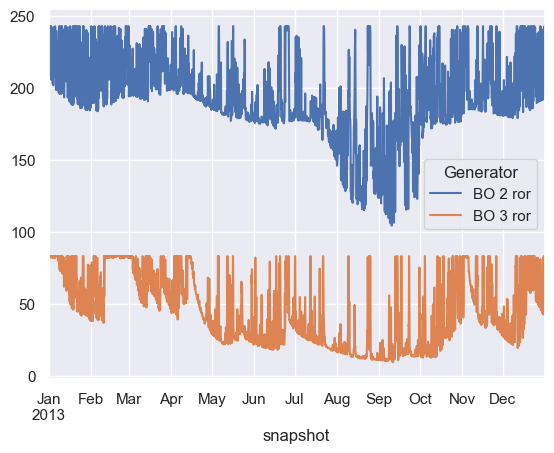

In [21]:
#n_solve_4.generators[n_solve_4.generators.carrier == 'ror']
#n_solve_4.generators_t.p
ror_generators = n_solve_4.generators[n_solve_4.generators.carrier == 'ror']
ror_columns = n_solve_4.generators_t.p.columns[n_solve_4.generators_t.p.columns.isin(ror_generators.index)]
ror_powerplants = n_solve_4.generators_t.p[ror_columns]
#ror_powerplants

ror_powerplants.plot()

In [96]:
ror_powerplants.sum().sum()/1e6

0.6483359571181238

In [23]:
n_solve_4.generators[['p_nom','p_nom_opt']]

,p_nom,p_nom_opt
Generator,,
BO 0 OCGT,5.715140e+02,5.942154e+02
BO 0 onwind,1.144228e+01,1.144304e+01
BO 0 solar,1.199526e+01,1.199650e+01
BO 1 OCGT,1.207441e+02,1.552365e+02
BO 1 oil,3.399651e+01,3.399651e+01
BO 1 onwind,7.377119e+00,7.377755e+00
BO 1 solar,5.066168e+01,1.306485e+03
BO 2 OCGT,7.224879e+01,2.459687e+02
BO 2 onwind,5.520645e+00,5.521523e+00


In [4]:
n_solve_4.loads

,bus,carrier,type,p_set,q_set,sign
Load,,,,,,
BO0 0,BO0 0,,,0.0,0.0,-1.0
BO0 1,BO0 1,,,0.0,0.0,-1.0
BO0 2,BO0 2,,,0.0,0.0,-1.0
BO0 3,BO0 3,,,0.0,0.0,-1.0
BO1 0,BO1 0,,,0.0,0.0,-1.0


In [8]:
n_solve_4.loads

,bus,carrier,type,p_set,q_set,sign
Load,,,,,,
BO0 0,BO0 0,,,0.0,0.0,-1.0
BO0 1,BO0 1,,,0.0,0.0,-1.0
BO0 2,BO0 2,,,0.0,0.0,-1.0
BO0 3,BO0 3,,,0.0,0.0,-1.0


In [9]:
a = n_solve_4.loads_t.p_set.sum().rename("load").rename_axis("bus")

a.rename("load", inplace=True)

a.rename_axis("bus", inplace=True)

a

bus
BO0 0    696047.926112
BO0 1    938059.317256
BO0 2    876926.056880
BO0 3    273916.219971
Name: load, dtype: float64

INFO:pypsa.io:Imported network elec_s_4_ec_lcopt_Co2L-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


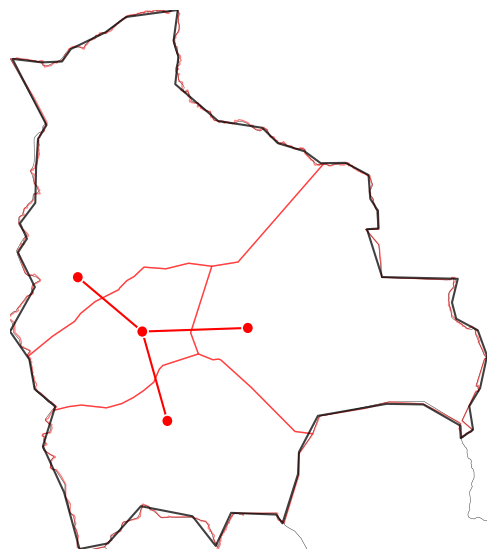

In [18]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
shapes=world[world.name.isin(["Bolivia"])].set_index("name")
country=shapes

solved_4_network = os.getcwd() +  "/results/networks/elec_s_4_ec_lcopt_Co2L-3H.nc"
n_solve_4 = pypsa.Network(solved_4_network)
c=4

n=n_solve_4

fig, ax = plt.subplots(figsize=(7, 7),subplot_kw={'projection': ccrs.PlateCarree()})

r = gpd.read_file(
        f"resources/bus_regions/regions_onshore_elec_s_4.geojson"
    ).set_index("name")
#factor = n.generators_t.p_max_pu.filter(like=plot_capfacs).mean()
#factor.index = [idx.split(f" {plot_capfacs}")[0] for idx in factor.index]
#r["factor"] = factor
    
n.plot(
        #color_geomap=True,
        bus_colors="red",
        #bus_sizes=red_bussizes,
        line_colors="red",
        #line_widths=red_linewidth,
        ax=ax,
    )

r.boundary.plot(ax=ax, color="red", linewidth=1, alpha=0.5)
#r.plot(ax=ax, alpha=1, vmin=0, vmax=1)
country.boundary.plot(ax=ax, color="black", alpha=0.75)
ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]], crs=ccrs.PlateCarree())

plt.show()

INFO:pypsa.io:Imported network elec_s_4_ec_lcopt_Co2L-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


(<matplotlib.collections.PatchCollection at 0x16ce3cf10>,
 <matplotlib.collections.LineCollection at 0x16ce51c60>)

/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


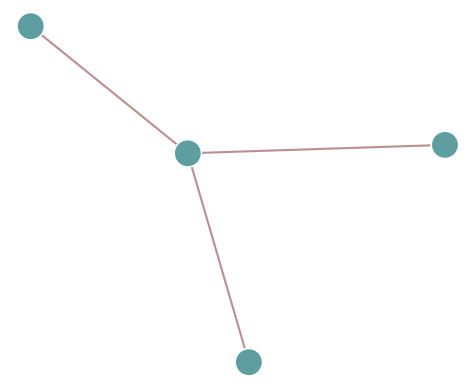

In [22]:
solved_4_network = os.getcwd() +  "/results/networks/elec_s_4_ec_lcopt_Co2L-3H.nc"
n_solve_4 = pypsa.Network(solved_4_network)
n_solve_4.plot()

INFO:pypsa.io:Imported network elec_s_5_ec_lcopt_Co2L-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


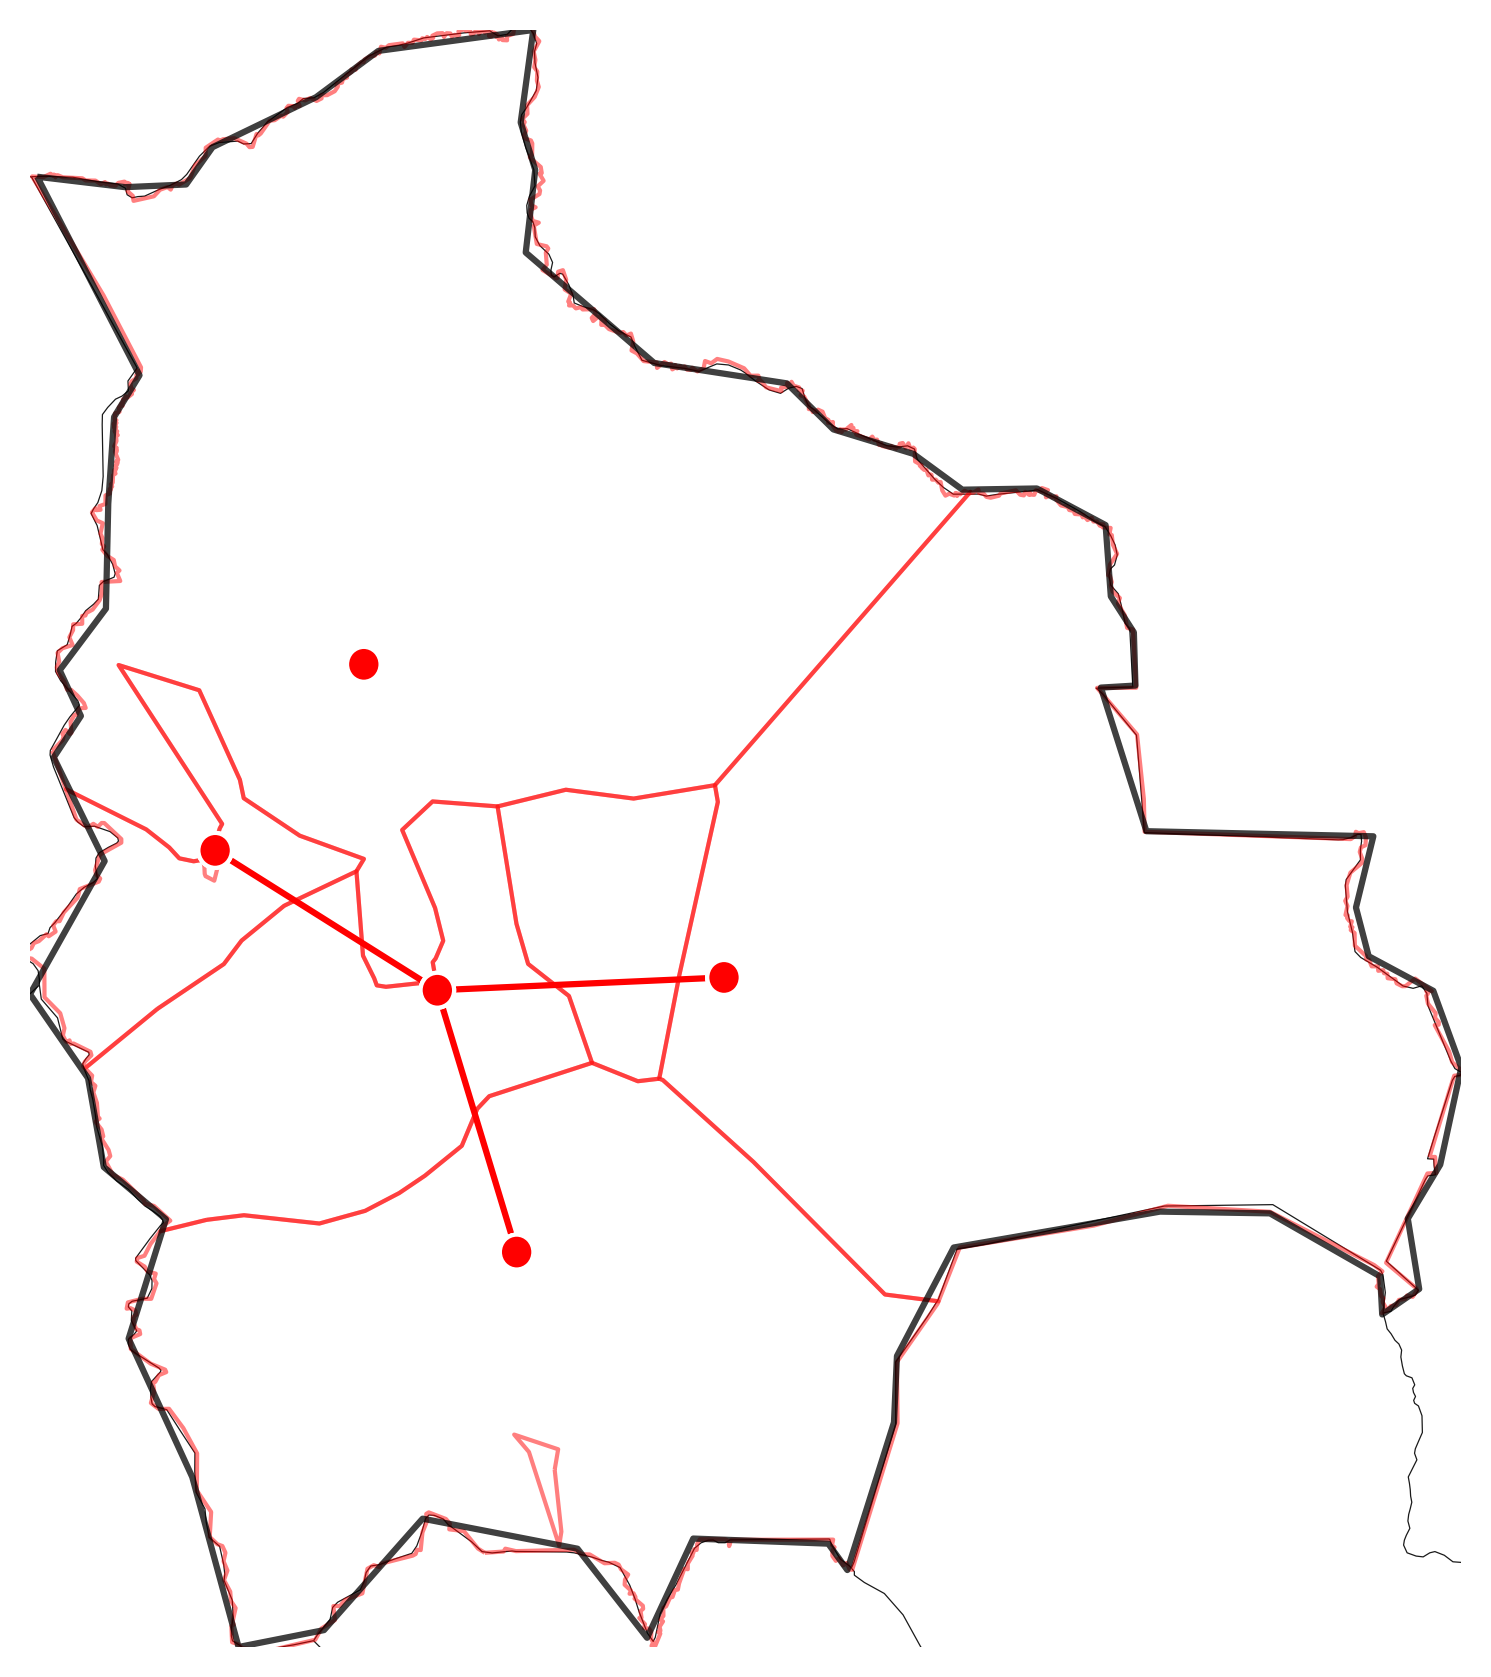

In [107]:
solved_5_network = os.getcwd() +  "/results/networks/results_old/elec_s_5_ec_lcopt_Co2L-3H.nc"
n_solve_5 = pypsa.Network(solved_5_network)

n=n_solve_5

fig, ax = plt.subplots(figsize=(7, 7),subplot_kw={'projection': ccrs.PlateCarree()})

r = gpd.read_file(
        f"resources/bus_regions/regions_onshore_elec_s_5.geojson"
    ).set_index("name")
#factor = n.generators_t.p_max_pu.filter(like=plot_capfacs).mean()
#factor.index = [idx.split(f" {plot_capfacs}")[0] for idx in factor.index]
#r["factor"] = factor
    
n.plot(
        #color_geomap=True,
        bus_colors="red",
        #bus_sizes=red_bussizes,
        line_colors="red",
        #line_widths=red_linewidth,
        ax=ax,
    )

r.boundary.plot(ax=ax, color="red", linewidth=1, alpha=0.5)
#r.plot(ax=ax, alpha=1, vmin=0, vmax=1)
country.boundary.plot(ax=ax, color="black", alpha=0.75)
ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]], crs=ccrs.PlateCarree())

plt.show()

### change in simplify network 

# Bottom up: see what are the input of build_renewable_profile

GEBCO: General Bathymetric Chart of the Oceans

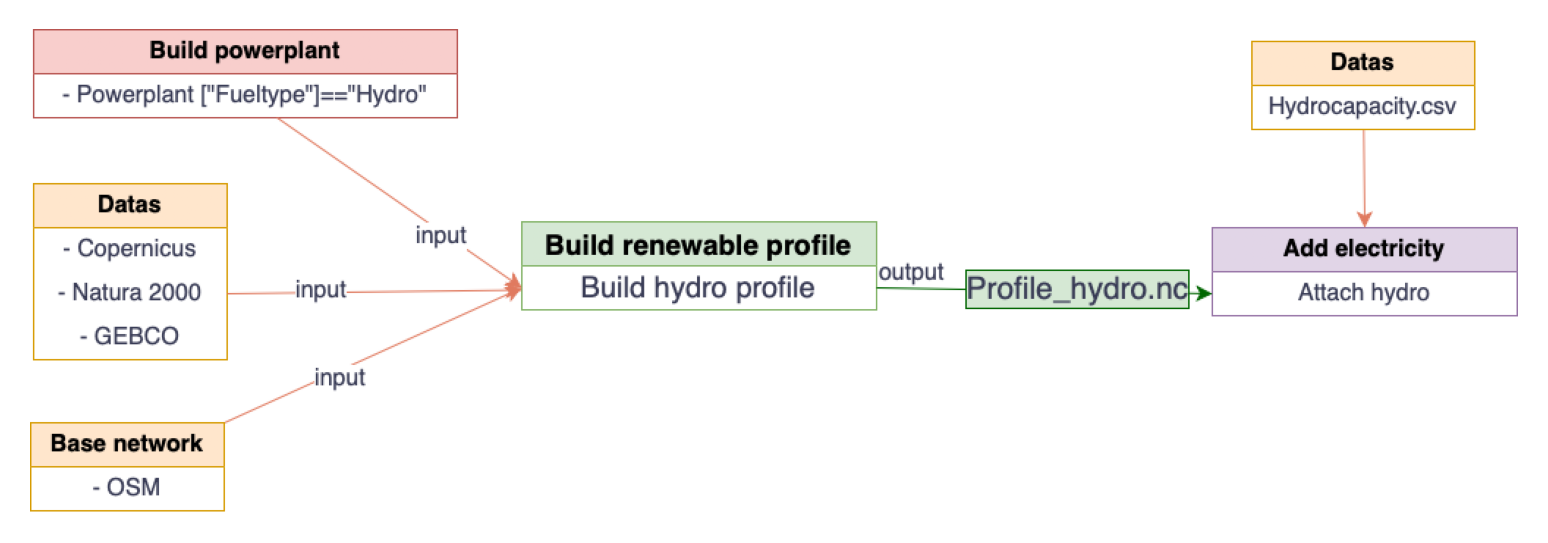

In [50]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import matplotlib as mpl

mpl.rcParams['figure.dpi']= 300
#mpl.rc("figure", dpi=200)
plt.grid(None) 
plt.axis('off')
plt.imshow(mpimg.imread(os.getcwd() +  "/post_process/datas_for_hydro.drawio.png"))
#plt.show()

Gebco: hydrobassins 

In [45]:
import xarray as xr
import pandas as pd
fp= os.getcwd() +  "/data/gebco/GEBCO_2021_TID.nc"
datas= xr.open_dataset(fp)
datas

<xarray.Dataset>
Dimensions:  (lon: 86400, lat: 43200)
Coordinates:
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat      (lat) float64 -90.0 -89.99 -89.99 -89.99 ... 89.99 89.99 89.99 90.0
Data variables:
    crs      |S1 ...
    tid      (lat, lon) int8 ...
Attributes: (12/31)
    title:                           The GEBCO_2021 Grid Type Identifier
    summary:                         The GEBCO_2021 Grid is a continuous, glo...
    keywords:                        BATHYMETRY/SEAFLOOR TOPOGRAPHY, DIGITAL ...
    Conventions:                     CF-1.6, ACDD-1.3
    id:                              DOI: 10.5285/c6612cbe-50b3-0cff-e053-6c8...
    naming_authority:                https://dx.doi.org
    ...                              ...
    geospatial_lon_max:              180.0
    geospatial_lon_units:            degrees_east
    geospatial_lon_resolution:       0.004166666666666667
    identifier_product_doi:          DOI: 10.5285/c6612cbe-50b3-0cff-e053-6c8...
    references:                      DOI: 10.5285/c6612cbe-50b3-0cff-e053-6c8...
    node_offset:                     1.0

In [46]:
tid=datas.data_vars['tid']
tid

<xarray.DataArray 'tid' (lat: 43200, lon: 86400)>
[3732480000 values with dtype=int8]
Coordinates:
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat      (lat) float64 -90.0 -89.99 -89.99 -89.99 ... 89.99 89.99 89.99 90.0
Attributes:
    long_name:           GEBCO Type Identifier
    units:               1.0
    grid_mapping:        crs
    sdn_parameter_urn:   SDN:P01::GEBCOSRC
    sdn_parameter_name:  Source identifer of GEBCO grid cell data
    sdn_uom_urn:         SDN:P06:UUUU
    sdn_uom_name:        Dimensionless
    flag_values:         [ 0 10 11 12 13 14 15 16 17 40 41 42 43 44 45 46 70 ...
    flag_meanings:       Land Singlebeam Multibeam Seismic Isolated_sounding ...

The TID grid identifies the type of source data that the corresponding grid cells in the GEBCO Grid are based on. 
More informations in https://www.gebco.net/data_and_products/gridded_bathymetry_data/gebco_2022/


In [ ]:
df=tid.to_dataframe()
df

Natura 2000

In [ ]:
import xarray as xr
import pandas as pd
fp= os.getcwd() +  "/resources/natura.tiff"
datas= xr.open_dataset(fp)
datas.data_vars['band_data']

#df=datas.data_vars['band_data'].to_dataframe()
#df

Copernicus = cutouts

In [ ]:
import xarray as xr
import pandas as pd
fp= os.getcwd() +  "/cutouts/southamerica-2013-era5.nc"
datas= xr.open_dataset(fp)
datas

In [ ]:
df=datas.data_vars['runoff'].to_dataframe()
df

Runoff occurs when there is more water than land can absorb

would need complex calculation to use this data

# Build_power_plant output (as input of build_renewable)

Graph of the dependencies for hydro build function

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import matplotlib as mpl

mpl.rcParams['figure.dpi']= 300
#mpl.rc("figure", dpi=200)
plt.grid(None) 
plt.axis('off')
plt.imshow(mpimg.imread(os.getcwd() +  "/post_process/workflow_hydro_dependencies.png"))
#plt.show()


In [ ]:
powerplant = pd.read_csv(os.getcwd() +  "/resources/powerplants.csv")
powerplant
powerplant

In [ ]:
powerplant[powerplant["Fueltype"]=="Hydro"]

# Spatial division

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


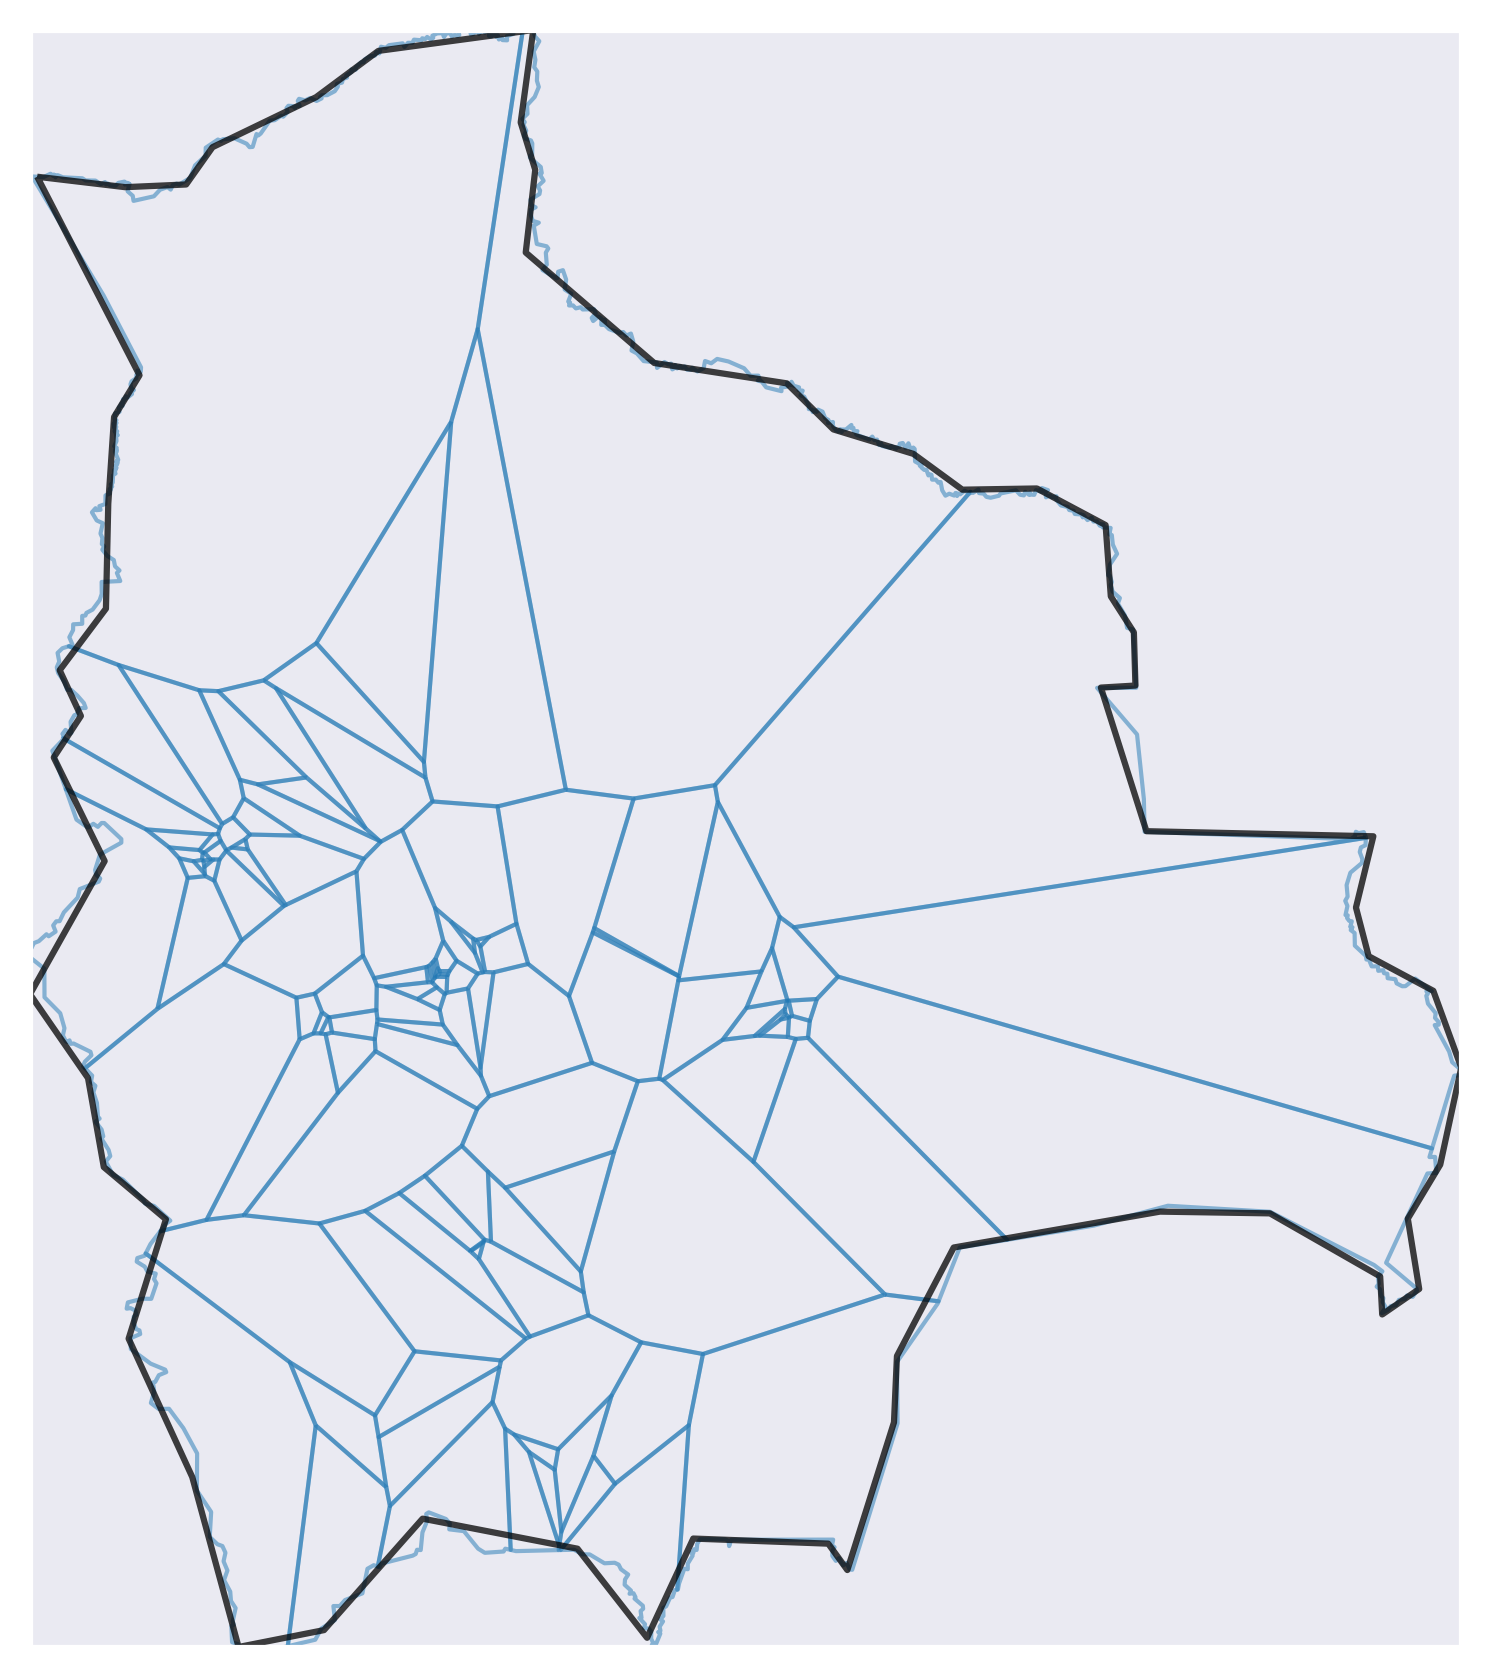

In [12]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
country=world[world.name.isin(["Bolivia"])].set_index("name")
shapes=country

fig, ax = plt.subplots(figsize=(7, 7),subplot_kw={'projection': ccrs.PlateCarree()})

r = gpd.read_file(
        f"resources/bus_regions/regions_onshore.geojson"
    ).set_index("name")


r.boundary.plot(ax=ax, color="tab:blue", linewidth=1, alpha=0.5)
country.boundary.plot(ax=ax, color="black", alpha=0.75)
ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]], crs=ccrs.PlateCarree())

# save the plot
image_format = 'eps' # e.g .png, .svg, etc.
fig.savefig('limits_hydro.eps', format=image_format, dpi=1200)

plt.show()

In [13]:
r

,x,y,country,shape_id,geometry
name,,,,,
0,-67.8350,-16.2861,BO,0,"POLYGON ((-67.93176 -16.41298, -67.97914 -16.33665, -68.00194 -16...."
1,-67.0450,-17.9693,BO,0,"POLYGON ((-66.67131 -18.04186, -66.98873 -18.37935, -67.09303 -17...."
4,-65.8005,-19.6076,BO,0,"POLYGON ((-65.87194 -19.66162, -66.47104 -19.19218, -66.25410 -19...."
6,-63.6302,-17.4271,BO,0,"POLYGON ((-63.53685 -17.69066, -63.73920 -17.95002, -64.24429 -18...."
7,-63.2364,-17.7429,BO,0,"POLYGON ((-63.24890 -17.78488, -63.42394 -17.91595, -63.46744 -17...."
...,...,...,...,...,...
126,-64.5716,-21.6177,BO,0,"POLYGON ((-64.64762 -21.54929, -64.02442 -21.07497, -64.12200 -22...."
127,-65.3106,-21.3888,BO,0,"POLYGON ((-65.11968 -22.05109, -65.37507 -21.29158, -65.15767 -21...."
128,-66.1176,-17.4490,BO,0,"POLYGON ((-66.07082 -17.56830, -66.08627 -17.57897, -66.15291 -17...."


ERROR:fiona._env:resources/bus_regions/regions_onshore_elec_s_37.geojson: No such file or directory


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "fiona/ogrext.pyx", line 136, in fiona.ogrext.gdal_open_vector
  File "fiona/_err.pyx", line 291, in fiona._err.exc_wrap_pointer
fiona._err.CPLE_OpenFailedError: resources/bus_regions/regions_onshore_elec_s_37.geojson: No such file or directory

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/adelehannotte/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/n4/_tj5q4j14x1btpmbdy4tlc780000gn/T/ipykernel_4705/1088390930.py", line 5, in <module>
    r = gpd.read_file(
  File "/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/geopandas/io/file.py", line 259, in _read_file
    return _read_file_fiona(
  File "/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/geopandas/io/file.py", line 303, in _read_file_fiona
    with reader(path_or_bytes, **

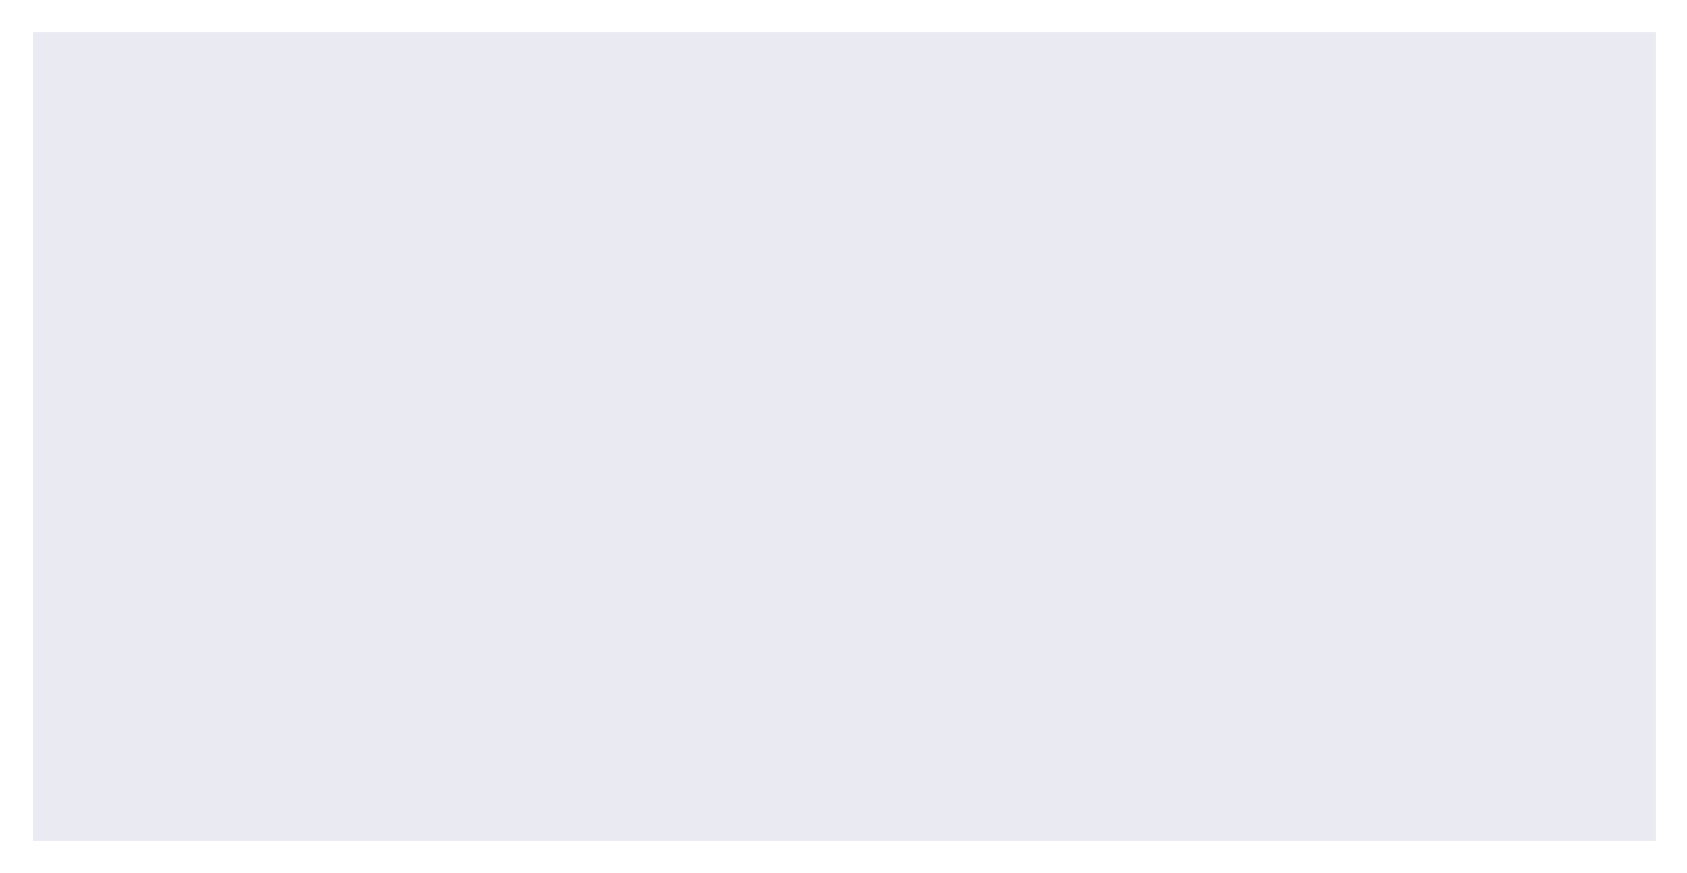

In [17]:
n=n_base

fig, ax = plt.subplots(figsize=(7, 7),subplot_kw={'projection': ccrs.PlateCarree()})

r = gpd.read_file(
        f"resources/bus_regions/regions_onshore_elec_s_37.geojson"
    ).set_index("name")

    
n.plot(
        color_geomap=None,
        bus_colors="chocolate",
        line_colors="tab:red",
        ax=ax,
    )

r.boundary.plot(ax=ax, color="tab:blue", linewidth=1, alpha=0.5)

country.boundary.plot(ax=ax, color="black", alpha=0.75)
ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]])


# save the plot
image_format = 'eps' # e.g .png, .svg, etc.
fig.savefig('limits_hydro_network.eps', format=image_format, dpi=1200)

plt.show()

# Copernicus datas

The Copernicus Global Land Service database provides a global 100 m x 100 m raster which, for each raster cell, indicates the type of landuse (forest, urban, industrial). In total there are 23 classes.

For calculating the availability per cutout weather cells, an ExclusionContainer must be defined beforehand. It serves as a container for all rasters and geometries we want to exclude (or possibly include).

In many cases, rasters and geometries have different projections and resolutions. Therefore, the ExclusionContainer is initialized by a CRS and a resolution which suits as a basis for all added rasters and geometries. Per default the CRS is 3035 and the resoultion 100, which leads set a raster of 100 meter resolution. All rasters and geometries will be converted to this (crs, res) config if they don't match it.

Some extra functionality which needs to be adjusted for the Copernicus data: When adding a raster to the ExclusionContainer you can specify which codes (integers) to exclude. By setting invert=True, you can also restrict the inclusion to a set of codes. Further you can buffer around codes (see the docs for detail). Here we are going to exclude some landuse areas (by code).

Further, we exclude special protected and reserved areas that are stored in the natura.tiff (build with the build_natura.py). The database we use for that is from https://www.protectedplanet.net/en that matches with national reported protected and reserved areas.

In [ ]:
import atlite
import pypsa
import cartopy.crs as ccrs
import cartopy
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import requests
import shutil
from rasterio.plot import show
from atlite.gis import shape_availability, ExclusionContainer
import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) # Ignore Shapely warnings

input_file = (
    "PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif"
)
input_filepath = os.path.join(os.getcwd(), "data", "copernicus", input_file)
CORINE = input_filepath
excluder = ExclusionContainer()
excluder.add_raster(
    CORINE,
    codes=[20, 30, 40, 50, 60, 90, 100],
    buffer=100,
    invert=True,
    crs="EPSG:4326",
)

### Natura 2000

In [ ]:
input_file = "natura.tiff"
input_filepath = os.path.join(os.getcwd(), "data", input_file)
natura = input_filepath
excluder = ExclusionContainer()
excluder.add_raster(natura, buffer=1000)

In [ ]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
country=world[world.name.isin(["Bolivia"])].set_index("name")
shapes=country

bolivia = shapes.loc[["Bolivia"]].geometry.to_crs(excluder.crs)
masked, transform = shape_availability(bolivia, excluder)

#shape_availability(country,excluder)

In [ ]:
eligible_share = masked.sum() * excluder.res**2 / bolivia.geometry.item().area

In [ ]:
fig, ax = plt.subplots()
ax = show(masked, transform=transform, cmap="Greens", ax=ax)
bolivia.plot(ax=ax, edgecolor="k", color="None")
ax.set_title(f"Eligible area (green) {eligible_share * 100:2.2f}%");

In [ ]:
existing_cutout_path = (
    os.path.realpath("/cutouts") + "/southamerica-2013-era5.nc"
)  # data for whole Africa
bounds = shapes.cascaded_union.buffer(1).bounds
cutout = atlite.Cutout(
    existing_cutout_path,
    module="era5",
    bounds=bounds,
    time=slice("2013-01-01", "2013-01-02"),
)

fig, ax = plt.subplots(figsize=(8, 4))
plt.rcParams.update({"font.size": 12})

# Plotting requirements
xlim = [bolivia.total_bounds[0], bolivia.total_bounds[2]]
ylim = [bolivia.total_bounds[1], bolivia.total_bounds[3]]
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = show(masked, transform=transform, cmap="Greens", ax=ax)
bolivia.plot(ax=ax, edgecolor="k", color="None")
cutout.grid.to_crs(excluder.crs).plot(edgecolor="grey", color="None", ax=ax, ls=":")
ax.set_title(
    f"Eligible area (green) in Bolivia: {eligible_share * 100:2.2f}%", fontsize=12
)

plt.xlabel("longitude (epsg:3035)")
plt.ylabel("latitude (epsg:3035)")

### Copernicus

In [ ]:
def plot_voronoi(n, carrier, voronoi, cmap, projection, title=None, filename=None):

    if carrier == "solar":
        capacity_per_sqkm = 4.6
    else:
        capacity_per_sqkm = 3.0

    g = n.generators.loc[n.generators.carrier == carrier]
    br = gpd.read_file(f"resources/bus_regions/regions_{voronoi}.geojson").set_index("name")
    br_area = br.to_crs("ESRI:54009")
    br_area = br_area.geometry.area * 1e-6
    br["p_nom_max"] = g.groupby("bus").sum().p_nom_max / br_area / capacity_per_sqkm

    fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={"projection": projection})
    plt.rcParams.update({"font.size": 10})
    br.plot(
        ax=ax,
        column="p_nom_max",
        transform=ccrs.PlateCarree(),
        linewidth=0.25,
        edgecolor="k",
        cmap=cmap,
        vmin=0,
        vmax=1,
        legend=True,
        legend_kwds={"label": r"Eligible Area [%]"},
    )
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS.with_scale("110m"))
    ax.set_extent([2, 14.5, 3, 14], crs=ccrs.PlateCarree())  # Nigeria
    #  ax.set_extent([-23, 55, -35, 40], crs=ccrs.PlateCarree())  # Africa

    if title is not None:
        plt.title(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")

In [ ]:
plot_voronoi(
    n_elec,
    "onwind",
    "onshore",
    "Blues",
    ccrs.Orthographic(),
    title="Onshore Wind Eligible Area [%]",
    # filename="onwind-cell.pdf",
)